In [124]:
!pip install pandas_ta

In [129]:
# Import necessary libraries
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime as dt
import csv

In [130]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [131]:
# Read Bitcoin historical data
headers = ["datetime", "open", "high", "low", "close", "volume"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/new project/btc_1h.csv", names=headers)

In [132]:
# Create new data with only the "close" column
close = data.filter(["close"])
close_array = close.values
train_close_len = math.ceil(len(close_array) * 0.8)

In [133]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)

In [134]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [135]:
# Create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [136]:
len(data)

35664

In [137]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=256, activation='relu', return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])
model.fit(X_train, y_train, epochs=10, batch_size=48, verbose=1)

Epoch 1/10
594/594 [==============================] - 117s 192ms/step - loss: 3.4279e-04 - mae: 0.0059
Epoch 2/10
594/594 [==============================] - 108s 181ms/step - loss: 7.9936e-05 - mae: 0.0050
Epoch 3/10
594/594 [==============================] - 99s 166ms/step - loss: 3.9988e-05 - mae: 0.0038
Epoch 4/10
594/594 [==============================] - 99s 167ms/step - loss: 3.6878e-05 - mae: 0.0036
Epoch 5/10
594/594 [==============================] - 100s 168ms/step - loss: 2.8746e-05 - mae: 0.0032
Epoch 6/10
594/594 [==============================] - 96s 161ms/step - loss: 2.7895e-05 - mae: 0.0032
Epoch 7/10
594/594 [==============================] - 100s 168ms/step - loss: 2.8413e-05 - mae: 0.0031
Epoch 8/10
594/594 [==============================] - 97s 164ms/step - loss: 2.6024e-05 - mae: 0.0030
Epoch 9/10
594/594 [==============================] - 96s 161ms/step - loss: 2.5168e-05 - mae: 0.0030
Epoch 10/10
594/594 [==============================] - 105s 177ms/step - loss:

In [138]:
# Create the testing dataset
test_data_full = scaled_data[train_close_len - 60:, :]
X_test_full, y_test_full = [], []

for i in range(60, len(test_data_full)):
    X_test_full.append(test_data_full[i - 60 : i, 0])
    y_test_full.append(test_data_full[i, 0])

X_test_full, y_test_full = np.array(X_test_full), np.array(y_test_full)
X_test_full = np.reshape(X_test_full, (X_test_full.shape[0], X_test_full.shape[1], 1))

In [139]:
# Predict with LSTM model
predictions_full = model.predict(X_test_full)
predictions_full = scaler.inverse_transform(predictions_full)

223/223 [==============================] - 6s 25ms/step


In [140]:
# Created a dataframe for plotting
plot_data = close[train_close_len:].copy()
plot_data["Predictions"] = np.nan
plot_data["Predictions"].iloc[-predictions_full.shape[0]:] = predictions_full.flatten()

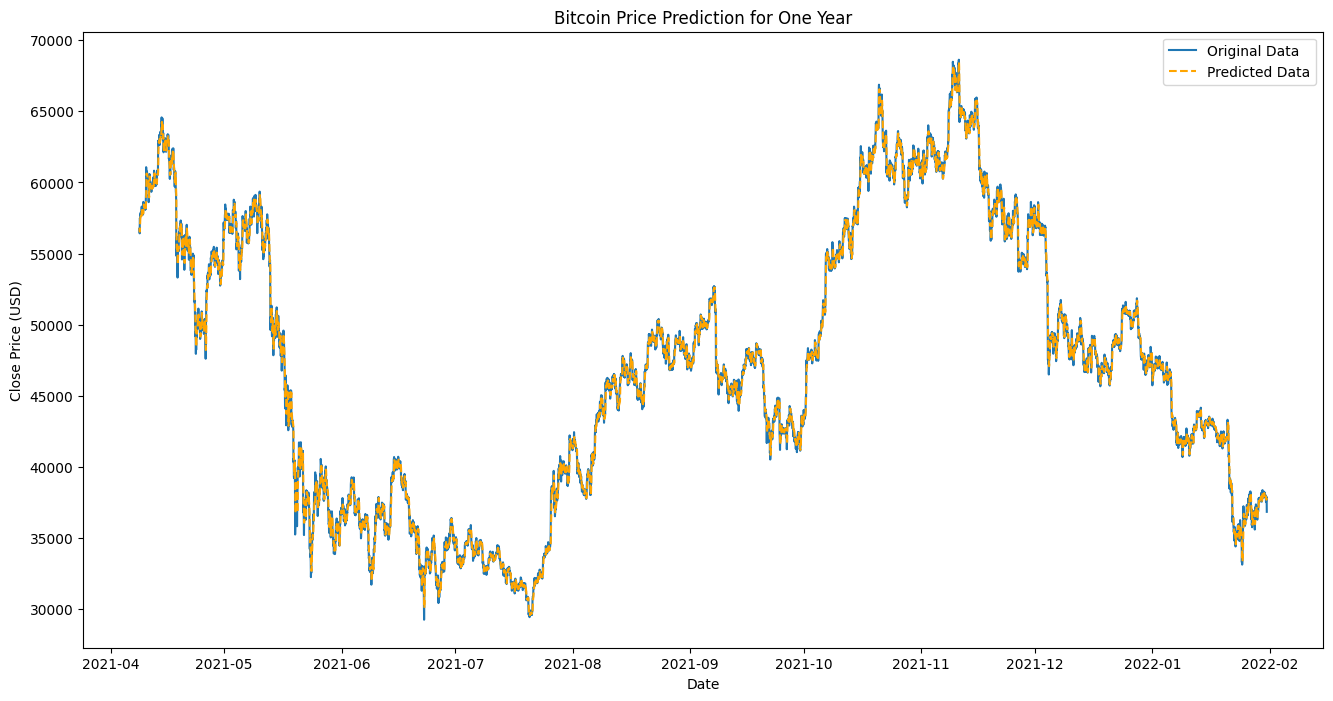

In [141]:
# Plot the original and predicted values for test region
import matplotlib.pyplot as plt
# Assuming the 'datetime' column is in string format, convert it to datetime
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')
# Plot the original and predicted values for test data with x-axis in date format
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(data['datetime'][train_close_len:], plot_data['close'], label='Original Data')
plt.plot(data['datetime'][train_close_len:], plot_data['Predictions'], label='Predicted Data', linestyle='dashed', color='orange')
plt.legend()
plt.show()


In [142]:
# Predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Create a dataframe for validation results
valid = close[train_close_len:].copy()
valid["Predictions"] = predictions

223/223 [==============================] - 6s 25ms/step


In [180]:
valid["Signal"] = 0
valid["Signal"][valid["Predictions"] > valid["close"]] = 1
valid["Signal"][valid["Predictions"] < valid["close"]] = -1

balance = 10000
bal=10000
position = 0
buy_price = 0
gross_profit = 0
gross_loss = 0
num_winning_trades = 0
num_losing_trades = 0
winning_trade_total = 0
losing_trade_total = 0
largest_winning_trade = 0
largest_losing_trade = 0
holding_durations = []
max_dips = []
average_dip = 0
total_holding_duration = 0
total_trades = 0
successful_trades = 0
max_balance = balance  # Initialize max_balance before the loop
drawdown = 0  # Initialize drawdown


for i in valid.index[1:]:
    if valid["Signal"].loc[i] == 1 and position == 0:
        position = 1
        buy_price = valid["close"].loc[i]
        total_trades += 1
    elif valid["Signal"].loc[i] == -1 and position == 1:
        position = 0
        balance *= valid["close"].loc[i] / buy_price
        total_trades += 1
        if balance > max_balance:
            max_balance = balance
        drawdown = max(drawdown, (max_balance - balance) / max_balance)
        if balance > 10000:
            successful_trades += 1
        profit_loss = balance - 10000
        if profit_loss > 0:
            gross_profit += profit_loss
            num_winning_trades += 1
            winning_trade_total += profit_loss
            largest_winning_trade = max(largest_winning_trade, profit_loss)
        else:
            gross_loss += abs(profit_loss)
            num_losing_trades += 1
            losing_trade_total += abs(profit_loss)
            largest_losing_trade = max(largest_losing_trade, abs(profit_loss))
        total_holding_duration += 1
        max_dip = (max_balance - balance) / max_balance
        max_dips.append(max_dip)
        average_dip = (average_dip * (total_holding_duration - 1) + max_dip) / total_holding_duration
    elif valid["Signal"].loc[i] == -1 and position == 0:
        position = -1
        buy_price = valid["close"].loc[i]
        total_trades += 1
    elif valid["Signal"].loc[i] == 1 and position == -1:
        position = 0
        balance *= buy_price / valid["close"].loc[i]
        total_trades += 1
        if balance > max_balance:
            max_balance = balance
        drawdown = max(drawdown, (max_balance - balance) / max_balance)
        if balance > 10000:
            successful_trades += 1
        profit_loss = balance - 10000
        if profit_loss > 0:
            gross_profit += profit_loss
            num_winning_trades += 1
            winning_trade_total += profit_loss
            largest_winning_trade = max(largest_winning_trade, profit_loss)
        else:
            gross_loss += abs(profit_loss)
            num_losing_trades += 1
            losing_trade_total += abs(profit_loss)
            largest_losing_trade = max(largest_losing_trade, abs(profit_loss))
        total_holding_duration += 1
        max_dip = (max_balance - balance) / max_balance
        max_dips.append(max_dip)
        average_dip = (average_dip * (total_holding_duration - 1) + max_dip) / total_holding_duration

In [181]:
# If there's a remaining position at the end, close it
if position != 0:
    balance *= valid["close"].iloc[-1] / buy_price
    total_trades += 1
    if balance > max_balance:
        max_balance = balance
    drawdown = max(drawdown, (max_balance - balance) / max_balance)
    if balance > 10000:
        successful_trades += 1
    profit_loss = balance - 10000
    if profit_loss > 0:
        gross_profit += profit_loss
        num_winning_trades += 1
        winning_trade_total += profit_loss
        largest_winning_trade = max(largest_winning_trade, profit_loss)
    else:
        gross_loss += abs(profit_loss)
        num_losing_trades += 1
        losing_trade_total += abs(profit_loss)
        largest_losing_trade = max(largest_losing_trade, abs(profit_loss))
    total_holding_duration += 1
    max_dip = (max_balance - balance) / max_balance
    max_dips.append(max_dip)
    average_dip = (average_dip * (total_holding_duration - 1) + max_dip) / total_holding_duration
gross_profit=(gross_profit/1000)
gross_loss=gross_loss/10

In [183]:
drad_pe=(largest_losing_trade/bal)*100

In [186]:
# Print additional metrics
print("Gross Profit in USDT:", gross_profit)
print("Gross Loss in USDT:", gross_loss)
print("Net Profit in USDT:", gross_profit - gross_loss)
print("Max Drawdown:",drad_pe,'%' )
print("Number of Winning Trades:", num_winning_trades)
print("Number of Losing Trades:", num_losing_trades)
print("Average Winning Trade (in USDT):", winning_trade_total / num_winning_trades if num_winning_trades > 0 else 0)
print("Average Losing Trade (in USDT):", losing_trade_total / num_losing_trades if num_losing_trades > 0 else 0)
print("Largest Winning Trade (in USDT):", largest_winning_trade)
print("Largest Losing Trade (in USDT):", largest_losing_trade)
print("Average Holding Duration per Trade:", total_holding_duration / total_trades)
print("Max Dip:", max(max_dips) * 100, "%")
print("Average Dip:", average_dip * 100, "%")

Gross Profit in USDT: 29436.031423097145
Gross Loss in USDT: 2154.658335203457
Net Profit in USDT: 27281.373087893688
Max Drawdown: 6.821495209469868 %
Number of Winning Trades: 1762
Number of Losing Trades: 75
Average Winning Trade (in USDT): 16706.03372479974
Average Losing Trade (in USDT): 287.2877780271276
Largest Winning Trade (in USDT): 37361.89196322473
Largest Losing Trade (in USDT): 682.1495209469867
Average Holding Duration per Trade: 0.5
Max Dip: 20.40096408643042 %
Average Dip: 4.669544161303796 %


20/20 [==============================] - 0s 18ms/step


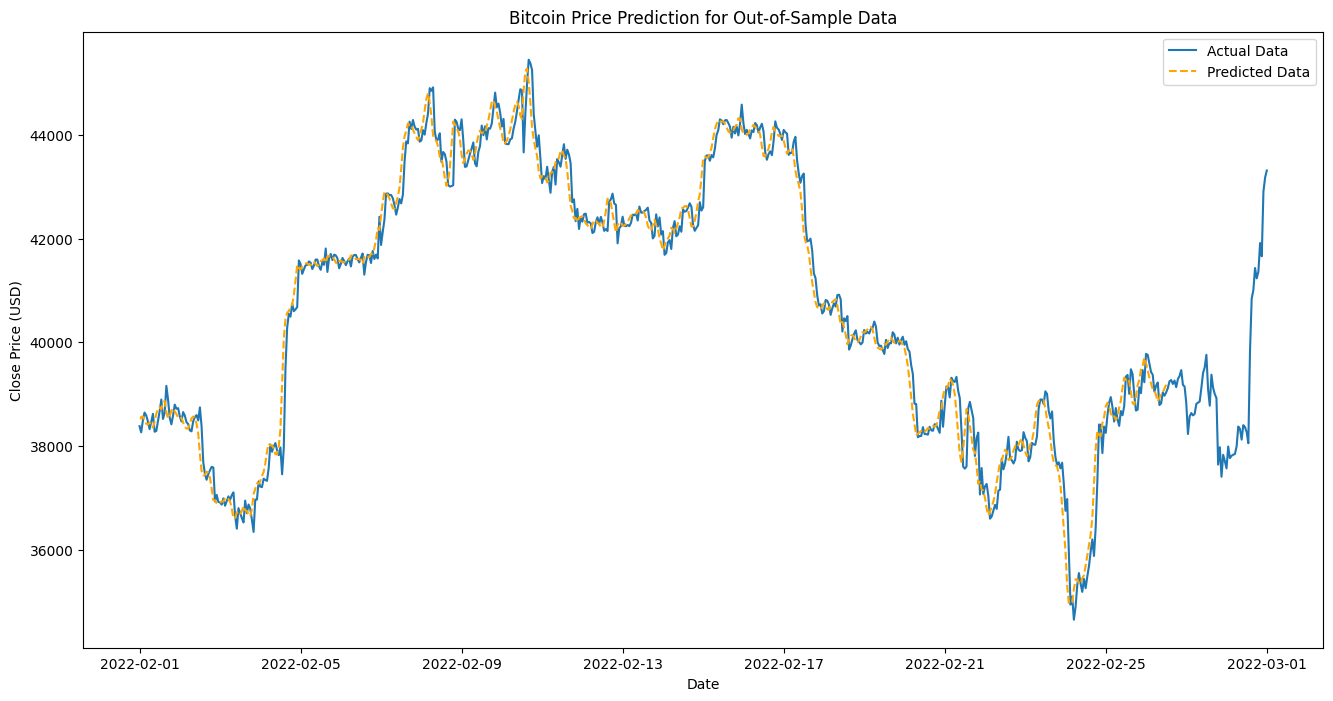

In [160]:
# Testing for out-of-sample dataset

# Load the out-of-sample dataset
out_of_sample_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/new project/outos.csv", names=headers)  # Update the path

# Create new data with only the "close" column for out-of-sample data
close_out_of_sample = out_of_sample_data.filter(["close"])
close_out_of_sample_array = close_out_of_sample.values

# Normalize the out-of-sample data using the same scaler used for training data
scaled_out_of_sample_data = scaler.transform(close_out_of_sample_array)

# Create the testing dataset for out-of-sample data
X_test_out_of_sample = []
for i in range(60, len(scaled_out_of_sample_data)):
    X_test_out_of_sample.append(scaled_out_of_sample_data[i - 60 : i, 0])

X_test_out_of_sample = np.array(X_test_out_of_sample)
X_test_out_of_sample = np.reshape(X_test_out_of_sample, (X_test_out_of_sample.shape[0], X_test_out_of_sample.shape[1], 1))

# Predict with the trained LSTM model for out-of-sample data
predictions_out_of_sample = model.predict(X_test_out_of_sample)
predictions_out_of_sample = scaler.inverse_transform(predictions_out_of_sample)

# Create a dataframe for plotting
plot_data_out_of_sample = close_out_of_sample.copy()
plot_data_out_of_sample["Predictions"] = np.nan
plot_data_out_of_sample["Predictions"].iloc[-predictions_out_of_sample.shape[0]:] = predictions_out_of_sample.flatten()

# Assuming the 'datetime' column is in string format, convert it to datetime
plot_data_out_of_sample['datetime'] = pd.to_datetime(out_of_sample_data['datetime'], format='%d-%m-%Y %H:%M')

# Plot the original and predicted values for out-of-sample data
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction for Out-of-Sample Data')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(plot_data_out_of_sample['datetime'], plot_data_out_of_sample['close'], label='Actual Data')
plt.plot(plot_data_out_of_sample['datetime'], plot_data_out_of_sample['Predictions'], label='Predicted Data', linestyle='dashed', color='orange')
plt.legend()
plt.show()
